# Main Figures 
Code generates figures for the main mediation analysis and for five-fold validation. It also contains the code to generate the final cohort selection figure. 

In [1]:
# Load necessary packages

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
from matplotlib.lines import Line2D

In [2]:
# Set global font 
plt.rcParams['font.family'] = 'Times New Roman'

### Mediation pathway figures

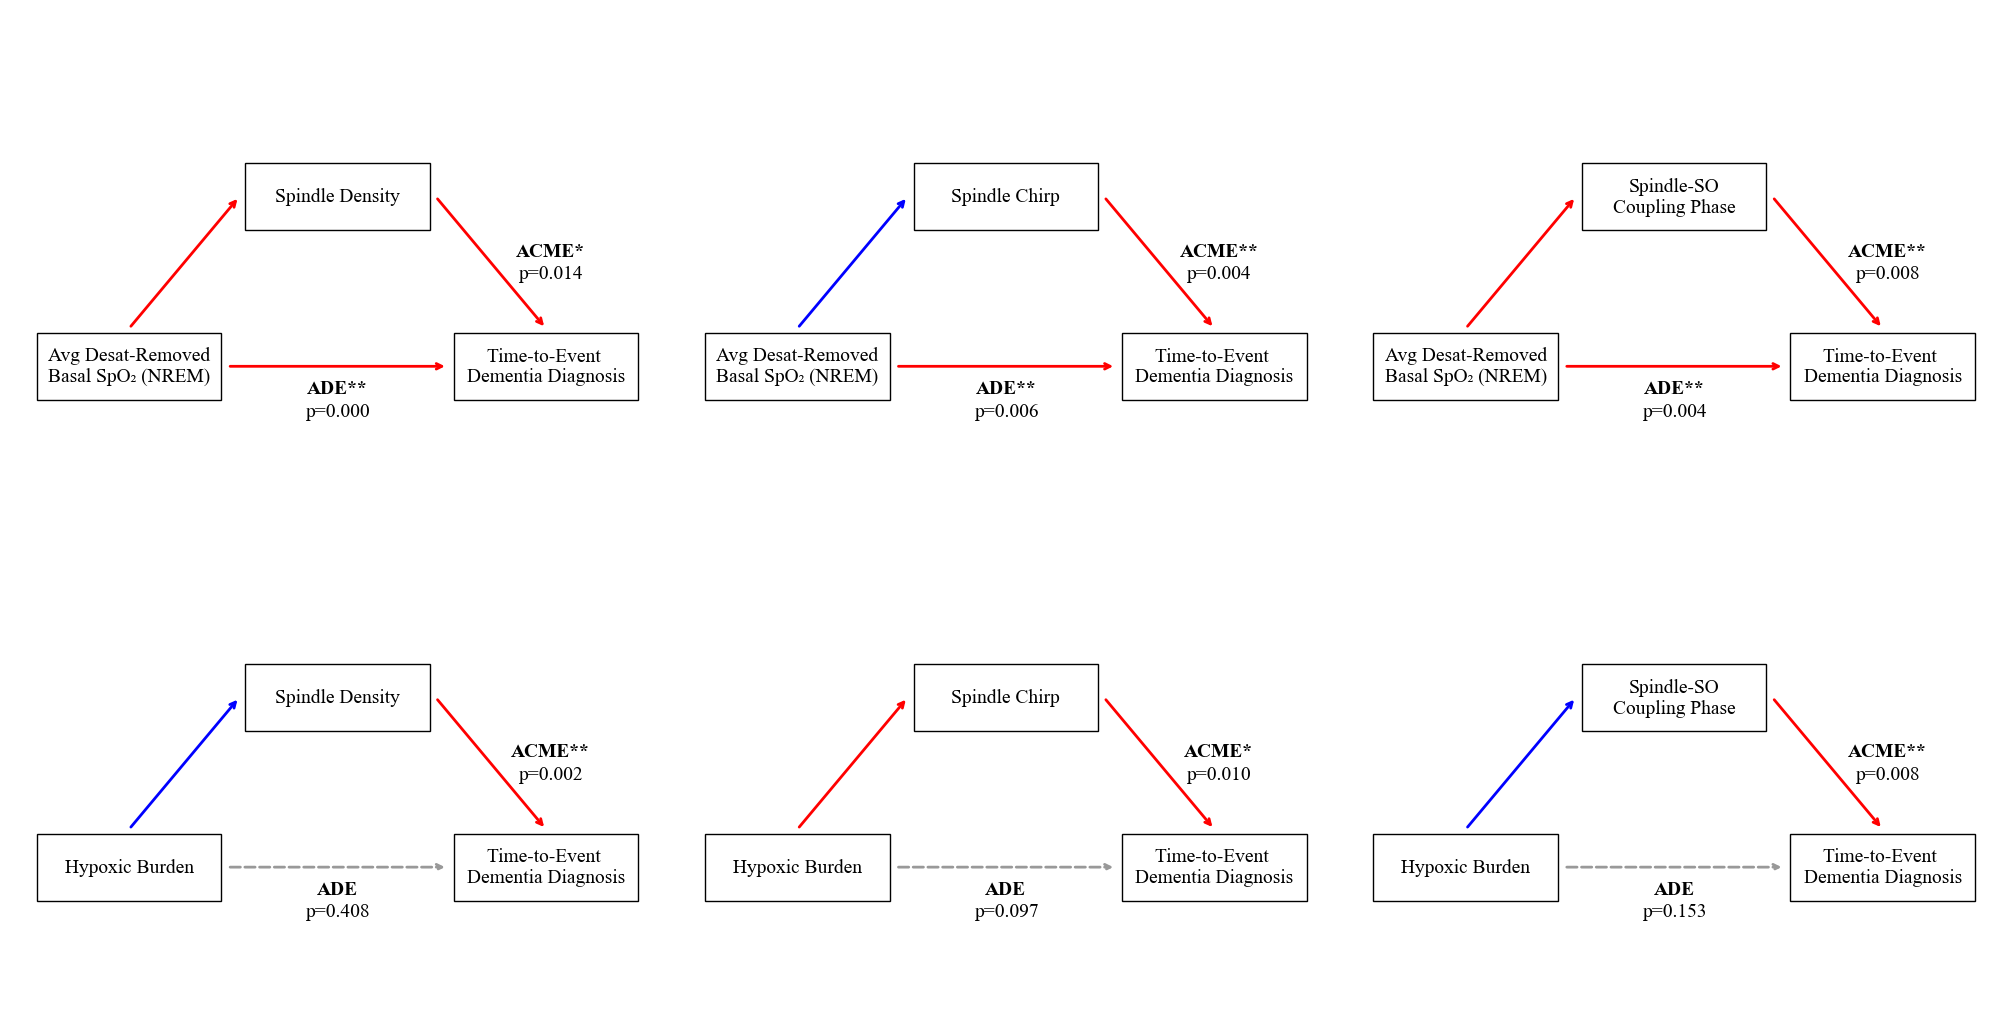

In [3]:
# Import unadjusted data
df = pd.read_excel("mediation_results_final_for_figures.xlsx", sheet_name="Unadjusted") 

# Set labels
outcome_label = "Time-to-Event \nDementia Diagnosis"
exposure_labels = {
    "avg_spo2_no_desat_NREM": "Avg Desat-Removed\nBasal SpO₂ (NREM)",
    "hb_desat": "Hypoxic Burden"
}
mediator_labels = {
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "Spindle-SO\nCoupling Phase"
}

# Set subplot positions
position_lookup = {
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"): (0, 0),
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"): (0, 1),
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"): (0, 2),
    ("hb_desat", "SP_DENS_all_C"): (1, 0),
    ("hb_desat", "SP_CHIRP_all_C"): (1, 1),
    ("hb_desat", "SP_R_PHASE_IF_all_C"): (1, 2)
}


# Manually enter correlation values
corr_lookup = {
    ("hb_desat", "SP_DENS_all_C"): -0.175,
    ("hb_desat", "SP_CHIRP_all_C"): 0.077,
    ("hb_desat", "SP_R_PHASE_IF_all_C"): -0.135,
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"): 0.063,
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"): -0.095,
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"): 0.065
}


# Create 2x3 panel
fig, axs = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

# Significance marker logic
def get_sig_marker(p):
    if p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Plot each model into appropriate panel
for index, row in df.iterrows():
    exposure_raw = row["Exposure"]
    mediator_raw = row["Mediator"]

    exposure = exposure_labels.get(exposure_raw, exposure_raw)
    mediator = mediator_labels.get(mediator_raw, mediator_raw)

    ACME = row["ACME"]
    ADE = row["ADE"]
    TE = row["Total_Effect"]
    ACME_pval = row["ACME_pval_empirical"]
    ADE_pval = row["ADE_pval_empirical"]

    row_idx, col_idx = position_lookup.get((exposure_raw, mediator_raw), (None, None))
    if row_idx is None:
        continue

    ax = axs[row_idx, col_idx]
    ax.axis('off')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 1.1)

    nodes = {
        exposure: (0.15, 0.3),
        mediator: (0.5, 0.68),
        outcome_label: (0.85, 0.3)
    }

    box_width = 0.31
    box_height = 0.15
    dx = box_width / 2 + 0.01
    dy = box_height / 2 + 0.01

    for label, (x, y) in nodes.items():
        facecolor = '#dddddd' if label == mediator and ACME_pval >= 0.05 else 'white'
        rect = patches.Rectangle((x - box_width/2, y - box_height/2),
                                 box_width, box_height,
                                 linewidth=1, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)
        ax.text(x, y, label, fontsize=14, ha='center', va='center')

    x1, y1 = nodes[exposure]
    x2, y2 = nodes[mediator]
    x3, y3 = nodes[outcome_label]

    # Arrow styles
    acme_linestyle = '-' if ACME_pval < 0.05 else 'dashed'
    ade_linestyle = '-' if ADE_pval < 0.05 else 'dashed'
    nonsig_color = '#999999'
    
    # Exposure → Mediator arrow
    corr = corr_lookup.get((exposure_raw, mediator_raw), 0)
    arrow_color = 'red' if corr > 0 else 'blue' if ACME_pval < 0.05 else nonsig_color

    ax.annotate("",
        xy=(x2 - dx, y2),
        xytext=(x1, y1 + dy),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=acme_linestyle, color=arrow_color))

    # Set sign flip for interpretability 
    # Flip BOTH exposures for unadjusted values 
    if exposure_raw == "hb_desat":
        signed_acme = -ACME
        signed_ade = -ADE
    else:
        signed_acme = -ACME
        signed_ade = -ADE

    # Mediator → Outcome arrow
    acme_color = 'red' if ACME_pval < 0.05 and signed_acme > 0 else 'blue' if ACME_pval < 0.05 else nonsig_color

    ax.annotate("",
        xy=(x3, y3 + dy),
        xytext=(x2 + dx, y2),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=acme_linestyle, color=acme_color))

    # Exposure → Outcome (ADE) arrow
    ade_color = 'red' if ADE_pval < 0.05 and signed_ade > 0 else 'blue' if ADE_pval < 0.05 else nonsig_color
    ax.annotate("",
        xy=(x3 - dx, y3),
        xytext=(x1 + dx, y1),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=ade_linestyle, color=ade_color))

    # Midpoints for labels
    acme_x = (x2 + dx + x3) / 2
    acme_y = (y2 + y3 + dy) / 2
    ade_x = (x1 + dx + x3 - dx) / 2
    ade_y = y1

    # Draw ACME label in two parts
    ax.text(acme_x + 0.1, acme_y + 0.025, f"ACME{get_sig_marker(ACME_pval)}",
            fontsize=14, ha='center', va='center', fontweight='bold')
    ax.text(acme_x + 0.1, acme_y - 0.025, f"p={ACME_pval:.3f}",
            fontsize=14, ha='center', va='center')

    # Draw ADE label in two parts
    ax.text(ade_x, ade_y - 0.05, f"ADE{get_sig_marker(ADE_pval)}",
            fontsize=14, ha='center', va='center', fontweight='bold')
    ax.text(ade_x, ade_y - 0.1, f"p={ADE_pval:.3f}",
            fontsize=14, ha='center', va='center')

# Save and show figure 
#plt.savefig("Figures/unadj_med_model_7.8.2025.png", dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

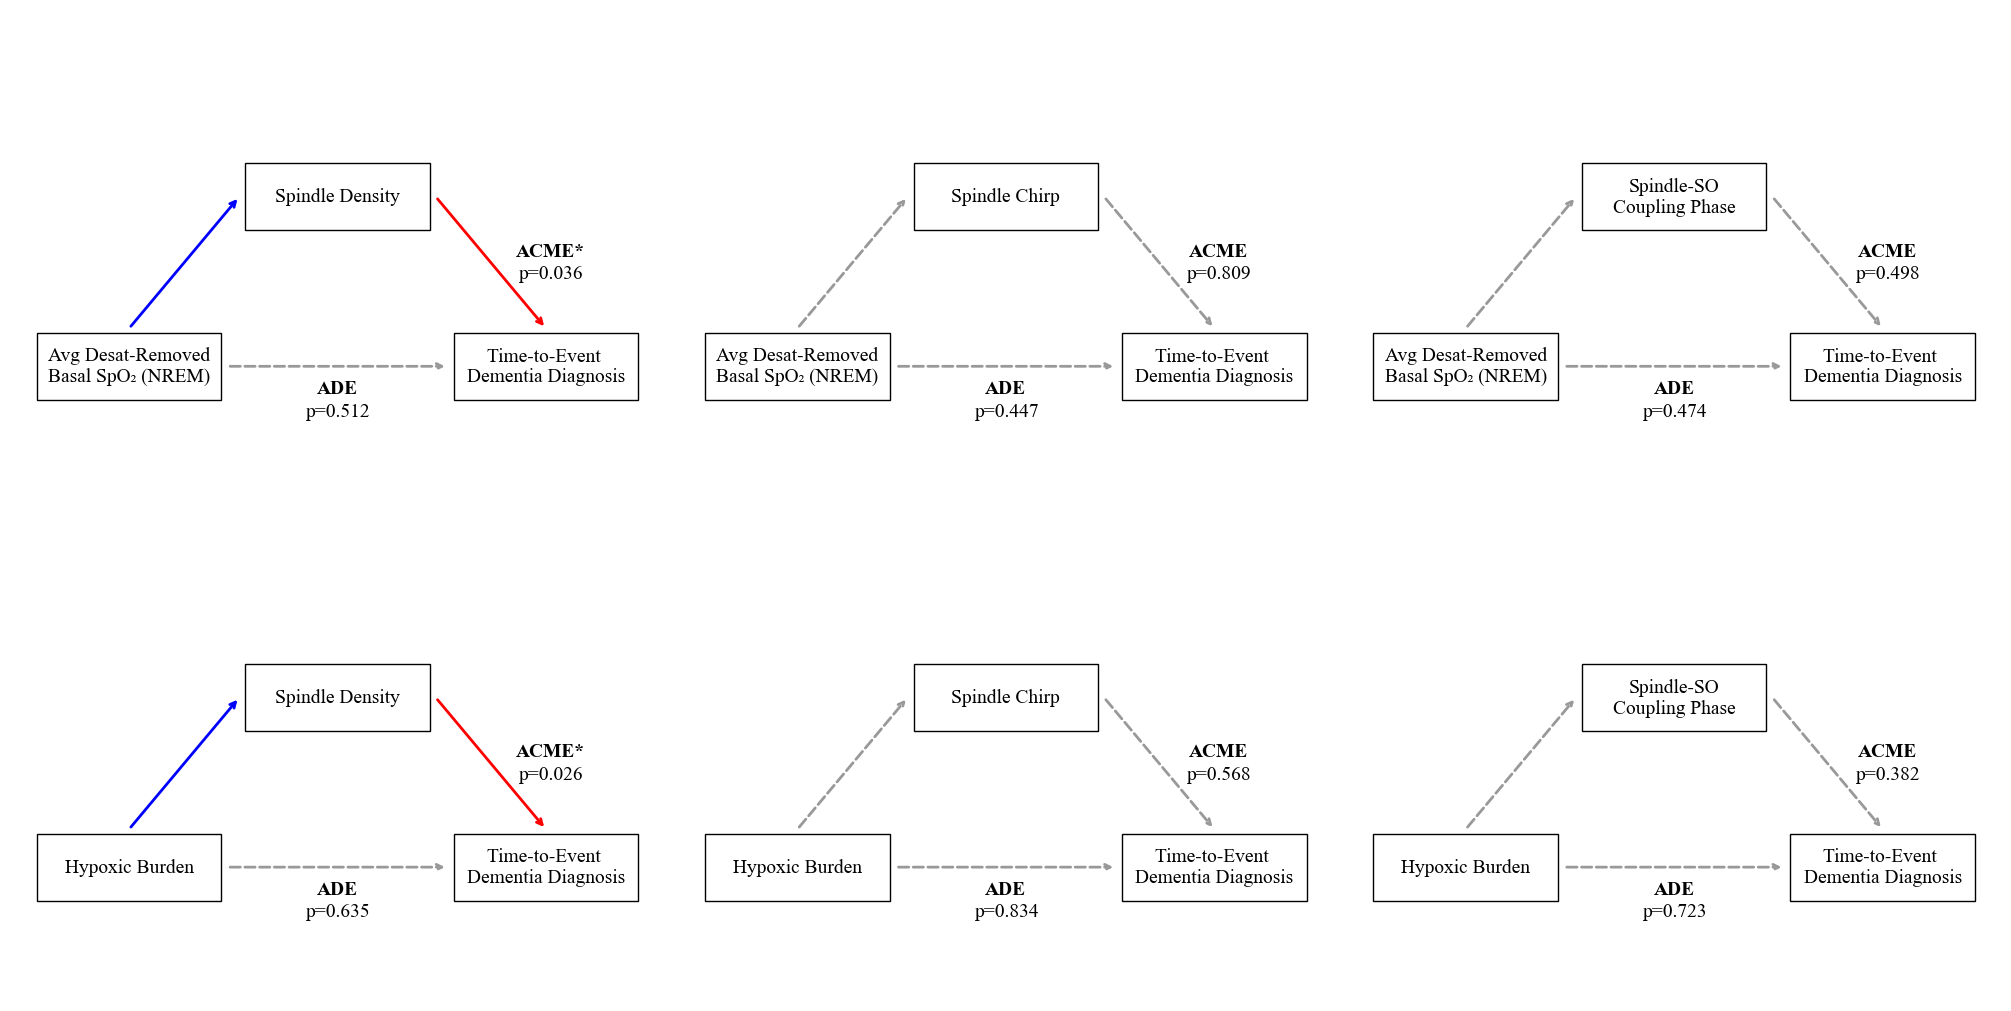

In [4]:
# Load Group 3 data
df = pd.read_excel("mediation_results_final_for_figures.xlsx", sheet_name="Group3")

# Set labels
outcome_label = "Time-to-Event \nDementia Diagnosis"
exposure_labels = {
    "avg_spo2_no_desat_NREM": "Avg Desat-Removed\nBasal SpO₂ (NREM)",
    "hb_desat": "Hypoxic Burden"
}
mediator_labels = {
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "Spindle-SO\nCoupling Phase"
}

# Track subplot positions
position_lookup = {
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"): (0, 0),
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"): (0, 1),
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"): (0, 2),
    ("hb_desat", "SP_DENS_all_C"): (1, 0),
    ("hb_desat", "SP_CHIRP_all_C"): (1, 1),
    ("hb_desat", "SP_R_PHASE_IF_all_C"): (1, 2)
}

# Manually enter correlation values (adjusted)
corr_lookup = {
    ("hb_desat", "SP_DENS_all_C"): -0.064,
    ("hb_desat", "SP_CHIRP_all_C"): -0.004,
    ("hb_desat", "SP_R_PHASE_IF_all_C"): -0.049,
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"): -0.059,
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"): -0.025,
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"): -0.026
}

# Create 2x3 panel
fig, axs = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

# Significance marker logic
def get_sig_marker(p):
    if p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Plot each model into appropriate panel
for index, row in df.iterrows():
    exposure_raw = row["Exposure"]
    mediator_raw = row["Mediator"]

    exposure = exposure_labels.get(exposure_raw, exposure_raw)
    mediator = mediator_labels.get(mediator_raw, mediator_raw)

    ACME = row["ACME"]
    ADE = row["ADE"]
    TE = row["Total_Effect"]
    ACME_pval = row["ACME_pval_empirical"]
    ADE_pval = row["ADE_pval_empirical"]

    row_idx, col_idx = position_lookup.get((exposure_raw, mediator_raw), (None, None))
    if row_idx is None:
        continue

    ax = axs[row_idx, col_idx]
    ax.axis('off')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 1.1)

    nodes = {
        exposure: (0.15, 0.3),
        mediator: (0.5, 0.68),
        outcome_label: (0.85, 0.3)
    }

    box_width = 0.31
    box_height = 0.15
    dx = box_width / 2 + 0.01
    dy = box_height / 2 + 0.01

    for label, (x, y) in nodes.items():
        rect = patches.Rectangle((x - box_width/2, y - box_height/2),
                                 box_width, box_height,
                                 linewidth=1, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)
        ax.text(x, y, label, fontsize=14, ha='center', va='center')

    x1, y1 = nodes[exposure]
    x2, y2 = nodes[mediator]
    x3, y3 = nodes[outcome_label]

    # Arrow styles
    acme_linestyle = '-' if ACME_pval < 0.05 else 'dashed'
    ade_linestyle = '-' if ADE_pval < 0.05 else 'dashed'
    nonsig_color = '#999999'
    
    # Exposure → Mediator arrow 
    corr = corr_lookup.get((exposure_raw, mediator_raw), 0)
    arrow_color = 'red' if corr > 0 else 'blue' if ACME_pval < 0.05 else nonsig_color

    ax.annotate("",
        xy=(x2 - dx, y2),
        xytext=(x1, y1 + dy),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=acme_linestyle, color=arrow_color))


    # Set sign flip for hb desat for interpretability 
    if exposure_raw == "hb_desat":
        signed_acme = -ACME
        signed_ade = -ADE
    else:
        signed_acme = ACME
        signed_ade = ADE
        
    # Mediator → Outcome arrow 
    acme_color = 'red' if ACME_pval < 0.05 and signed_acme > 0 else 'blue' if ACME_pval < 0.05 else nonsig_color

    ax.annotate("",
        xy=(x3, y3 + dy),
        xytext=(x2 + dx, y2),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=acme_linestyle, color=acme_color))

    # Exposure → Outcome (ADE) arrow 
    ade_color = 'red' if ADE_pval < 0.05 and signed_ade > 0 else 'blue' if ADE_pval < 0.05 else nonsig_color
    ax.annotate("",
        xy=(x3 - dx, y3),
        xytext=(x1 + dx, y1),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=ade_linestyle, color=ade_color))

    # Midpoints for labels
    acme_x = (x2 + dx + x3) / 2
    acme_y = (y2 + y3 + dy) / 2
    ade_x = (x1 + dx + x3 - dx) / 2
    ade_y = y1

    # Draw ACME label in two parts
    ax.text(acme_x + 0.1, acme_y + 0.025, f"ACME{get_sig_marker(ACME_pval)}",
            fontsize=14, ha='center', va='center', fontweight='bold')
    ax.text(acme_x + 0.1, acme_y - 0.025, f"p={ACME_pval:.3f}",
            fontsize=14, ha='center', va='center')

    # Draw ADE label in two parts
    ax.text(ade_x, ade_y - 0.05, f"ADE{get_sig_marker(ADE_pval)}",
            fontsize=14, ha='center', va='center', fontweight='bold')
    ax.text(ade_x, ade_y - 0.1, f"p={ADE_pval:.3f}",
            fontsize=14, ha='center', va='center')

# Save and show figure
#plt.savefig("Figures/group3_med_model_7.8.2025.png", dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


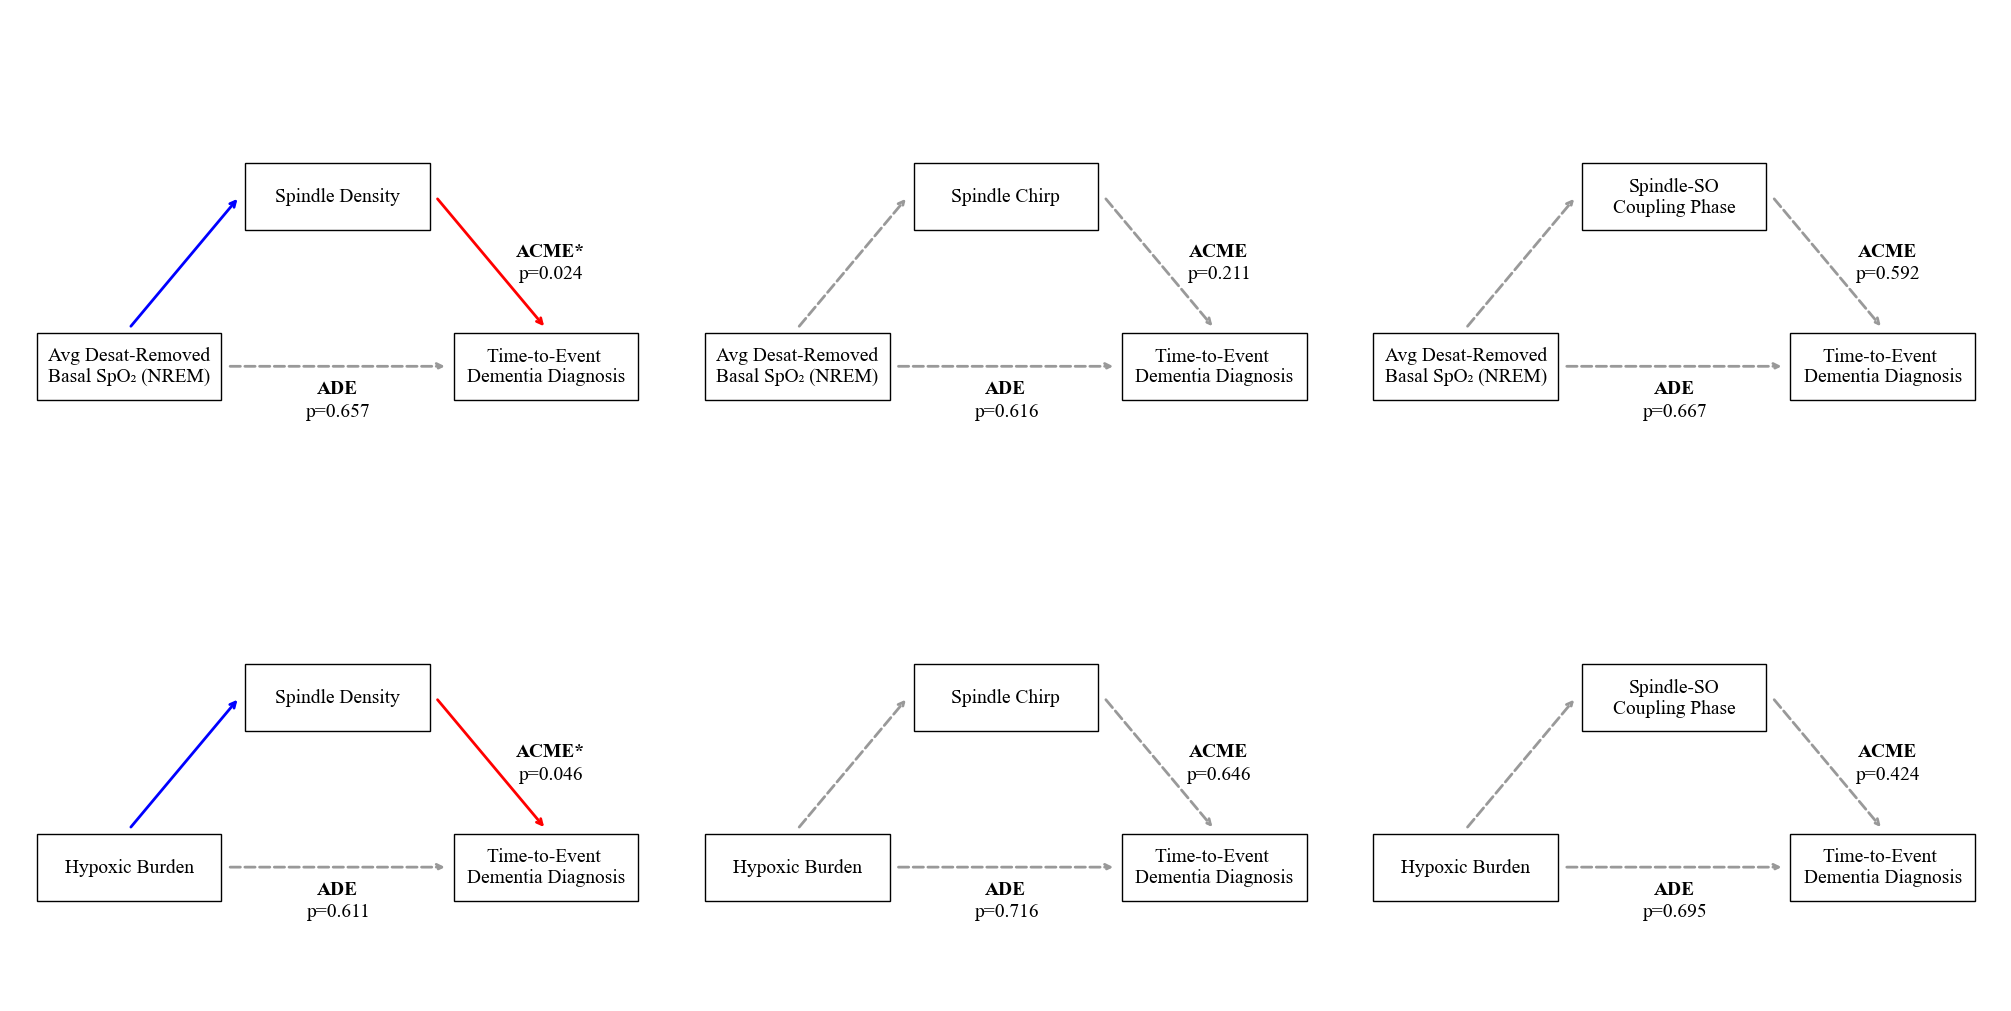

In [5]:
# Load Group 1 data
df = pd.read_excel("mediation_results_final_for_figures.xlsx", sheet_name="Group1")

# Set labels
outcome_label = "Time-to-Event \nDementia Diagnosis"
exposure_labels = {
    "avg_spo2_no_desat_NREM": "Avg Desat-Removed\nBasal SpO₂ (NREM)",
    "hb_desat": "Hypoxic Burden"
}
mediator_labels = {
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "Spindle-SO\nCoupling Phase"
}

# Track subplot positions
position_lookup = {
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"): (0, 0),
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"): (0, 1),
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"): (0, 2),
    ("hb_desat", "SP_DENS_all_C"): (1, 0),
    ("hb_desat", "SP_CHIRP_all_C"): (1, 1),
    ("hb_desat", "SP_R_PHASE_IF_all_C"): (1, 2)
}

# Manually enter correlation values (adjusted)
corr_lookup = {
    ("hb_desat", "SP_DENS_all_C"): -0.064,
    ("hb_desat", "SP_CHIRP_all_C"): -0.004,
    ("hb_desat", "SP_R_PHASE_IF_all_C"): -0.049,
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"): -0.059,
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"): -0.025,
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"): -0.026
}

# Create 2x3 panel
fig, axs = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

# Significance marker logic
def get_sig_marker(p):
    if p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Plot each model into appropriate panel
for index, row in df.iterrows():
    exposure_raw = row["Exposure"]
    mediator_raw = row["Mediator"]

    exposure = exposure_labels.get(exposure_raw, exposure_raw)
    mediator = mediator_labels.get(mediator_raw, mediator_raw)

    ACME = row["ACME"]
    ADE = row["ADE"]
    TE = row["Total_Effect"]
    ACME_pval = row["ACME_pval_empirical"]
    ADE_pval = row["ADE_pval_empirical"]

    row_idx, col_idx = position_lookup.get((exposure_raw, mediator_raw), (None, None))
    if row_idx is None:
        continue

    ax = axs[row_idx, col_idx]
    ax.axis('off')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 1.1)

    nodes = {
        exposure: (0.15, 0.3),
        mediator: (0.5, 0.68),
        outcome_label: (0.85, 0.3)
    }

    box_width = 0.31
    box_height = 0.15
    dx = box_width / 2 + 0.01
    dy = box_height / 2 + 0.01

    for label, (x, y) in nodes.items():
        rect = patches.Rectangle((x - box_width/2, y - box_height/2),
                                 box_width, box_height,
                                 linewidth=1, edgecolor='black', facecolor=facecolor)
        ax.add_patch(rect)
        ax.text(x, y, label, fontsize=14, ha='center', va='center')

    x1, y1 = nodes[exposure]
    x2, y2 = nodes[mediator]
    x3, y3 = nodes[outcome_label]

    # Arrow styles
    acme_linestyle = '-' if ACME_pval < 0.05 else 'dashed'
    ade_linestyle = '-' if ADE_pval < 0.05 else 'dashed'
    nonsig_color = '#999999'
    
    # Exposure → Mediator arrow 
    corr = corr_lookup.get((exposure_raw, mediator_raw), 0)
    arrow_color = 'red' if corr > 0 else 'blue' if ACME_pval < 0.05 else nonsig_color

    ax.annotate("",
        xy=(x2 - dx, y2),
        xytext=(x1, y1 + dy),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=acme_linestyle, color=arrow_color))

    # Set sign flip for hb desat for interpretability 
    if exposure_raw == "hb_desat":
        signed_acme = -ACME
        signed_ade = -ADE
    else:
        signed_acme = ACME
        signed_ade = ADE
        
    # Mediator → Outcome arrow 
    acme_color = 'red' if ACME_pval < 0.05 and signed_acme > 0 else 'blue' if ACME_pval < 0.05 else nonsig_color

    ax.annotate("",
        xy=(x3, y3 + dy),
        xytext=(x2 + dx, y2),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=acme_linestyle, color=acme_color))

    # Exposure → Outcome (ADE) arrow 
    ade_color = 'red' if ADE_pval < 0.05 and signed_ade > 0 else 'blue' if ADE_pval < 0.05 else nonsig_color
    ax.annotate("",
        xy=(x3 - dx, y3),
        xytext=(x1 + dx, y1),
        arrowprops=dict(arrowstyle='->', lw=2, linestyle=ade_linestyle, color=ade_color))

    # Midpoints for labels
    acme_x = (x2 + dx + x3) / 2
    acme_y = (y2 + y3 + dy) / 2
    ade_x = (x1 + dx + x3 - dx) / 2
    ade_y = y1

    # Draw ACME label in two parts
    ax.text(acme_x + 0.1, acme_y + 0.025, f"ACME{get_sig_marker(ACME_pval)}",
            fontsize=14, ha='center', va='center', fontweight='bold')
    ax.text(acme_x + 0.1, acme_y - 0.025, f"p={ACME_pval:.3f}",
            fontsize=14, ha='center', va='center')

    # Draw ADE label in two parts
    ax.text(ade_x, ade_y - 0.05, f"ADE{get_sig_marker(ADE_pval)}",
            fontsize=14, ha='center', va='center', fontweight='bold')
    ax.text(ade_x, ade_y - 0.1, f"p={ADE_pval:.3f}",
            fontsize=14, ha='center', va='center')

# Save and show figure
#plt.savefig("Figures/group1_med_model_7.8.2025.png", dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


### Cohort figure after inclusion/exclusion 

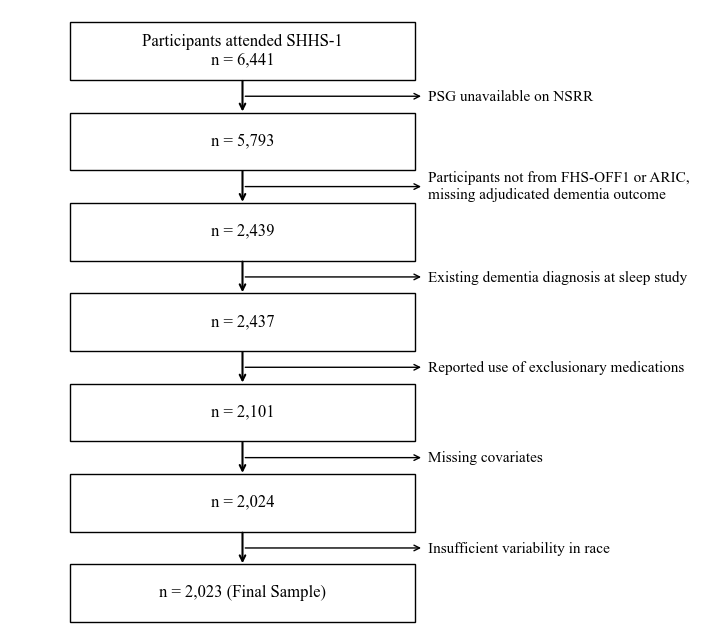

In [6]:
# Create figure space 
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 1.0)

ax.axis('off')

# Set box positions
box_coords = [
    (0.5, 0.9),
    (0.5, 0.68),
    (0.5, 0.46),
    (0.5, 0.24),
    (0.5, 0.02),
    (0.5, -0.20),
    (0.5, -0.42)
]


# Box text placeholders for number participants 
box_texts = [
    "Participants attended SHHS-1\nn = 6,441",
    "n = 5,793",
    "n = 2,439",
    "n = 2,437",
    "n = 2,101",
    "n = 2,024",
    "n = 2,023 (Final Sample)"
]

# Exclusion reasons
reasons = [
    "PSG unavailable on NSRR",
    "Participants not from FHS-OFF1 or ARIC, \nmissing adjudicated dementia outcome",
    "Existing dementia diagnosis at sleep study",
    "Reported use of exclusionary medications",
    "Missing covariates", 
    "Insufficient variability in race"
]

# Styling
box_width = 0.7
box_height = 0.1
linewidth = 1

# Draw boxes 
for i, (x, y) in enumerate(box_coords):
    rect = patches.FancyBboxPatch(
        (x - box_width / 2, y - box_height / 2),
        box_width,
        box_height,
        boxstyle="square,pad=0.02",
        edgecolor='black',
        facecolor='white',
        linewidth=linewidth
    )
    ax.add_patch(rect)
    ax.text(x, y, box_texts[i], ha='center', va='center', fontsize=12)

    # Add arrows and reasons
    if i < len(box_coords) - 1:
        # Vertical arrow
        arrow_buffer = 0.016  
        x0, y0 = x, y - box_height / 2 - arrow_buffer 
        x1, y1 = x, box_coords[i+1][1] + box_height / 2 + arrow_buffer  
        
        # Annotation 
        mid_y = (y0 + y1) / 2
        ax.annotate("",
                    xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(arrowstyle='->', lw=1.5, color='black'))

        # Right-pointing arrow from vertical midline
        reason_x = x + box_width / 2 + 0.05
        ax.annotate("",
                    xy=(reason_x - 0.01, mid_y),
                    xytext=(x, mid_y),
                    arrowprops=dict(arrowstyle='->', lw=1.0, color='black'))
       
        # Modify annotation for reason 1 to keep it central 
        if i == 1:
            ax.text(reason_x, mid_y + 0.0375,
                reasons[i], va='top', ha='left', fontsize=11, linespacing=1.3)
        else:
            ax.text(reason_x, mid_y + 0.015,
                reasons[i], va='top', ha='left', fontsize=11, linespacing=1.3)
        
        

# Save and show 
#plt.savefig("Figures/flowchart_cohort_selection.png", dpi=300, bbox_inches='tight')
plt.show()


### Main mediation results table

In [7]:
# Load data
unadjusted = pd.read_excel("med_results_AUC_C_CI.xlsx", sheet_name="Unadjusted")
group1 = pd.read_excel("med_results_AUC_C_CI.xlsx", sheet_name="Group1")
group2 = pd.read_excel("med_results_AUC_C_CI.xlsx", sheet_name="Group2")
group3 = pd.read_excel("med_results_AUC_C_CI.xlsx", sheet_name="Group3")

# Label each set
def label_df(df, label):
    df = df.copy()
    df["Covariates"] = label
    return df

all_data = pd.concat([
    label_df(unadjusted, "Unadjusted"),
    label_df(group1, "Group 1"),
    label_df(group2, "Group 2"),
    label_df(group3, "Group 3")
])

# Rename columns
rename_dict = {
    "Exposure": "Exposure",
    "Mediator": "Mediator",
    "Covariates": "Covariates",
    "ACME": "ACME",
    "ACME_Control": "ACME Control",
    "ACME_Treated": "ACME Treated",
    "ACME_CI_Lower": "ACME 95% CI Low",
    "ACME_CI_Upper": "ACME 95% CI High",
    "ACME_pval_empirical": "ACME p-value",
    "ADE": "ADE",
    "ADE_Control": "ADE Control",
    "ADE_Treated": "ADE Treated",
    "ADE_CI_Lower": "ADE 95% CI Low",
    "ADE_CI_Upper": "ADE 95% CI High",
    "ADE_pval_empirical": "ADE p-value",
    "Total_Effect": "TE",
    "Total_Effect_CI_Lower": "TE 95% CI Low",
    "Total_Effect_CI_Upper": "TE 95% CI High",
    "TE_pval_empirical": "TE p-value",
    "RMSE": "RMSE",
    "Std_Dev_Y": "SD (Mediator)",
    "C_Index": "C-index",
    "C_Index_CI_Lower": "C-index 95% CI Low",
    "C_Index_CI_Upper": "C-index 95% CI High",
    "AUC_10y": "AUC (10y)",
    "AUC_10y_CI_Lower": "AUC (10y) 95% CI Low",
    "AUC_10y_CI_Upper": "AUC (10y) 95% CI High",
    "AUC_15y": "AUC (15y)",
    "AUC_15y_CI_Lower": "AUC (15y) 95% CI Low",
    "AUC_15y_CI_Upper": "AUC (15y) 95% CI High",   
    "Prop_Mediated": "Proportion Mediated"
}
all_data.columns = all_data.columns.str.strip()
filtered_df = all_data.rename(columns=rename_dict)

# Replace exposure and mediator names 
filtered_df["Exposure"] = filtered_df["Exposure"].replace({
    "avg_spo2_no_desat_NREM": "Avg Baseline SpO₂ NREM",
    "hb_desat": "Hypoxic Burden"
})
filtered_df["Mediator"] = filtered_df["Mediator"].replace({
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "SO Phase Coupling"
})

# Calculate proportion mediated as a percent and absolute value 
filtered_df["Proportion Mediated"] = pd.to_numeric(filtered_df["Proportion Mediated"], errors='coerce')
filtered_df["|Proportion \nMediated (%)|"] = abs(filtered_df["Proportion Mediated"] * 100)

# Apply sign flip for Hypoxic Burden models 
mask = filtered_df["Exposure"] == "Hypoxic Burden"
cols_to_flip = [
    "ACME", "ADE", "TE",
    "ACME 95% CI Low", "ACME 95% CI High",
    "ADE 95% CI Low", "ADE 95% CI High",
    "TE 95% CI Low", "TE 95% CI High"
]
for col in cols_to_flip:
    filtered_df.loc[mask, col] = -1 * pd.to_numeric(filtered_df.loc[mask, col], errors='coerce')

# Apply rounding and format to keep CI ranges in same cell as the value 
def format_with_ci(value, ci_low, ci_high):
    def custom_fmt(v):
        v = float(v)
        return f"{v:.3f}" if abs(v) < 1 else f"{v:.1f}"
    try:
        return f"{custom_fmt(value)}\n[{custom_fmt(ci_low)}-{custom_fmt(ci_high)}]"
    except:
        return value

# Format ACME, ADE, TE  
# Use if statement to flip the CI range for hypoxic burden (to account for sign flip) 
for metric in ["ACME", "ADE", "TE"]:
    filtered_df[f"{metric} 95% CI"] = filtered_df.apply(
        lambda row: format_with_ci(
            row[metric],
            row[f"{metric} 95% CI High"] if row["Exposure"] == "Hypoxic Burden" else row[f"{metric} 95% CI Low"],
            row[f"{metric} 95% CI Low"] if row["Exposure"] == "Hypoxic Burden" else row[f"{metric} 95% CI High"]
        ),
        axis=1
    )

# Format C-index and AUCs similarly 
filtered_df["C-index 95% CI"] = filtered_df.apply(
    lambda row: format_with_ci(row["C-index"], row["C-index 95% CI Low"], row["C-index 95% CI High"]), axis=1)

filtered_df["AUC (10y) 95% CI"] = filtered_df.apply(
    lambda row: format_with_ci(row["AUC (10y)"], row["AUC (10y) 95% CI Low"], row["AUC (10y) 95% CI High"]), axis=1)

filtered_df["AUC (15y) 95% CI"] = filtered_df.apply(
    lambda row: format_with_ci(row["AUC (15y)"], row["AUC (15y) 95% CI Low"], row["AUC (15y) 95% CI High"]), axis=1)

# Drop CI columns now embedded
filtered_df.drop(columns=[
    "ACME 95% CI Low", "ACME 95% CI High",
    "ADE 95% CI Low", "ADE 95% CI High",
    "TE 95% CI Low", "TE 95% CI High",
    "C-index 95% CI Low", "C-index 95% CI High",
    "AUC (10y) 95% CI Low", "AUC (10y) 95% CI High",
    "AUC (15y) 95% CI Low", "AUC (15y) 95% CI High"
], inplace=True)

# Format p-values with asterisk annoation 
def format_p_value(val):
    try:
        val = float(val)
        if val < 0.01:
            return f"{val:.3f}**"
        elif val < 0.05:
            return f"{val:.3f}*"
        else:
            return f"{val:.3f}"
    except:
        return val

for col in ["ACME p-value", "ADE p-value", "TE p-value"]:
    filtered_df[col] = filtered_df[col].apply(format_p_value)

# Final column order
filtered_df = filtered_df[[
    "Exposure", "Mediator",
    "ACME", "ACME 95% CI", "ACME p-value",
    "ADE", "ADE 95% CI", "ADE p-value",
    "TE", "TE 95% CI", "TE p-value",
    "|Proportion \nMediated (%)|", 
    "RMSE", "SD (Mediator)",
    "C-index 95% CI",
    "AUC (10y) 95% CI",
    "AUC (15y) 95% CI",
    "Covariates"
]]

# Output preview
print(filtered_df.head())

                 Exposure           Mediator        ACME  \
0  Avg Baseline SpO₂ NREM    Spindle Density -458.299488   
1  Avg Baseline SpO₂ NREM      Spindle Chirp -572.531229   
2  Avg Baseline SpO₂ NREM  SO Phase Coupling -357.425482   
3          Hypoxic Burden    Spindle Density  250.507338   
4          Hypoxic Burden      Spindle Chirp   77.254344   

               ACME 95% CI ACME p-value          ADE  \
0   -458.3\n[-847.7--98.6]       0.014* -3121.264174   
1  -572.5\n[-987.2--266.8]      0.004** -3098.242815   
2  -357.4\n[-659.1--131.0]      0.008** -3259.906478   
3     250.5\n[158.0-365.4]      0.002**   163.167408   
4       77.3\n[22.6-144.1]       0.010*   330.355224   

                   ADE 95% CI ADE p-value           TE  \
0  -3121.3\n[-5142.3--1162.0]     0.000** -3473.583674   
1   -3098.2\n[-5004.8--995.7]     0.006** -3539.485454   
2  -3259.9\n[-5199.5--1220.9]     0.004** -3531.486446   
3       163.2\n[-254.0-492.9]       0.408   410.405850   
4        330

In [8]:
# Split the dataset into performance and results 

performance = filtered_df[["Exposure", "Mediator", "RMSE", "SD (Mediator)", 'C-index 95% CI', 'AUC (10y) 95% CI', 'AUC (15y) 95% CI', 'Covariates']].copy()

results = filtered_df[['Exposure', 'Mediator', 'ACME 95% CI', 'ACME p-value', 
       'ADE 95% CI', 'ADE p-value', 'TE 95% CI', 'TE p-value',
       '|Proportion \nMediated (%)|', 'Covariates']].copy()

# Specify notation for hypoxic burden sign flip 
results["Exposure"] = results["Exposure"].replace({
    "Hypoxic Burden": "Hypoxic Burden (T)"})

In [9]:
# Output results to Excel 
#results.to_excel("NAME FILE.xlsx", index=False)

In [10]:
# Output performance to excel 
#performance.to_excel("NAME FILE.xlsx", index=False)

### Five-fold validation figures

In [11]:
# Import data for all folds  
kfold_dataset0 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_0")
kfold_dataset1 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_1")
kfold_dataset2 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_2")
kfold_dataset3 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_3")
kfold_dataset4 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_4")

In [12]:
# Preview significant ACME p values across folds and covariate groups  
fold_dfs =[kfold_dataset0, kfold_dataset1, kfold_dataset2, kfold_dataset3, kfold_dataset4]
for i, df in enumerate(fold_dfs):
    print(f"\nFold {i}")
    sig_rows = df[df["ACME_pval_empirical"] < 0.05]
    for _, row in sig_rows.iterrows():
        print(f"  Exposure: {row['Exposure']}, Mediator: {row['Mediator']}, Covariates: {row['Covariate_Set']}, p = {row['ACME_pval_empirical']:.3f}")



Fold 0
  Exposure: avg_spo2_no_desat_NREM, Mediator: SP_DENS_all_C, Covariates: Unadjusted, p = 0.036
  Exposure: avg_spo2_no_desat_NREM, Mediator: SP_CHIRP_all_C, Covariates: Unadjusted, p = 0.002
  Exposure: avg_spo2_no_desat_NREM, Mediator: SP_R_PHASE_IF_all_C, Covariates: Unadjusted, p = 0.014
  Exposure: hb_desat, Mediator: SP_DENS_all_C, Covariates: Unadjusted, p = 0.010
  Exposure: hb_desat, Mediator: SP_CHIRP_all_C, Covariates: Unadjusted, p = 0.012
  Exposure: hb_desat, Mediator: SP_R_PHASE_IF_all_C, Covariates: Unadjusted, p = 0.010
  Exposure: avg_spo2_no_desat_NREM, Mediator: SP_DENS_all_C, Covariates: Group1, p = 0.024
  Exposure: hb_desat, Mediator: SP_DENS_all_C, Covariates: Group1, p = 0.016
  Exposure: avg_spo2_no_desat_NREM, Mediator: SP_DENS_all_C, Covariates: Group2, p = 0.022
  Exposure: hb_desat, Mediator: SP_DENS_all_C, Covariates: Group2, p = 0.008
  Exposure: avg_spo2_no_desat_NREM, Mediator: SP_DENS_all_C, Covariates: Group3, p = 0.032
  Exposure: hb_desat, M

In [13]:
# Filter data to show results for two main significant pathways (avg basal spo2 desaturation-removed NREM--spindle density AND hypoxic burden--spindle density) 
fold_dfs = [kfold_dataset0, kfold_dataset1, kfold_dataset2, kfold_dataset3, kfold_dataset4]

# Starting with hypoxic burden 
hb_density_rows = []
for i, df in enumerate(fold_dfs):
    new = df[(df["Exposure"] == "hb_desat") &
        (df["Mediator"] == "SP_DENS_all_C")].copy()
    new["Fold"] = f"Fold {i}"
    hb_density_rows.append(new)
    
# Concatenate into a single DataFrame
hb_density_df = pd.concat(hb_density_rows, ignore_index=True)

# Flip signs for Hypoxic Burden → Spindle Density pathway for interpretability 
cols_to_flip = ["ACME", "ADE", 
                "ACME_CI_Lower", "ACME_CI_Upper", 
                "ADE_CI_Lower", "ADE_CI_Upper", 
                "Total_Effect_CI_Lower", "Total_Effect_CI_Upper", "Total_Effect"]
for col in cols_to_flip:
    hb_density_df[col] = -1 * hb_density_df[col].astype(float)


# Repeat for spo2--spindle density pathway 
spo2_density_rows = []
for i, df in enumerate(fold_dfs):
    new = df[
        (df["Exposure"] == "avg_spo2_no_desat_NREM") &
        (df["Mediator"] == "SP_DENS_all_C")
    ].copy()
    new["Fold"] = f"Fold {i}"
    spo2_density_rows.append(new)
    
# Concatenate into a single DataFrame
spo2_density_df = pd.concat(spo2_density_rows, ignore_index=True)


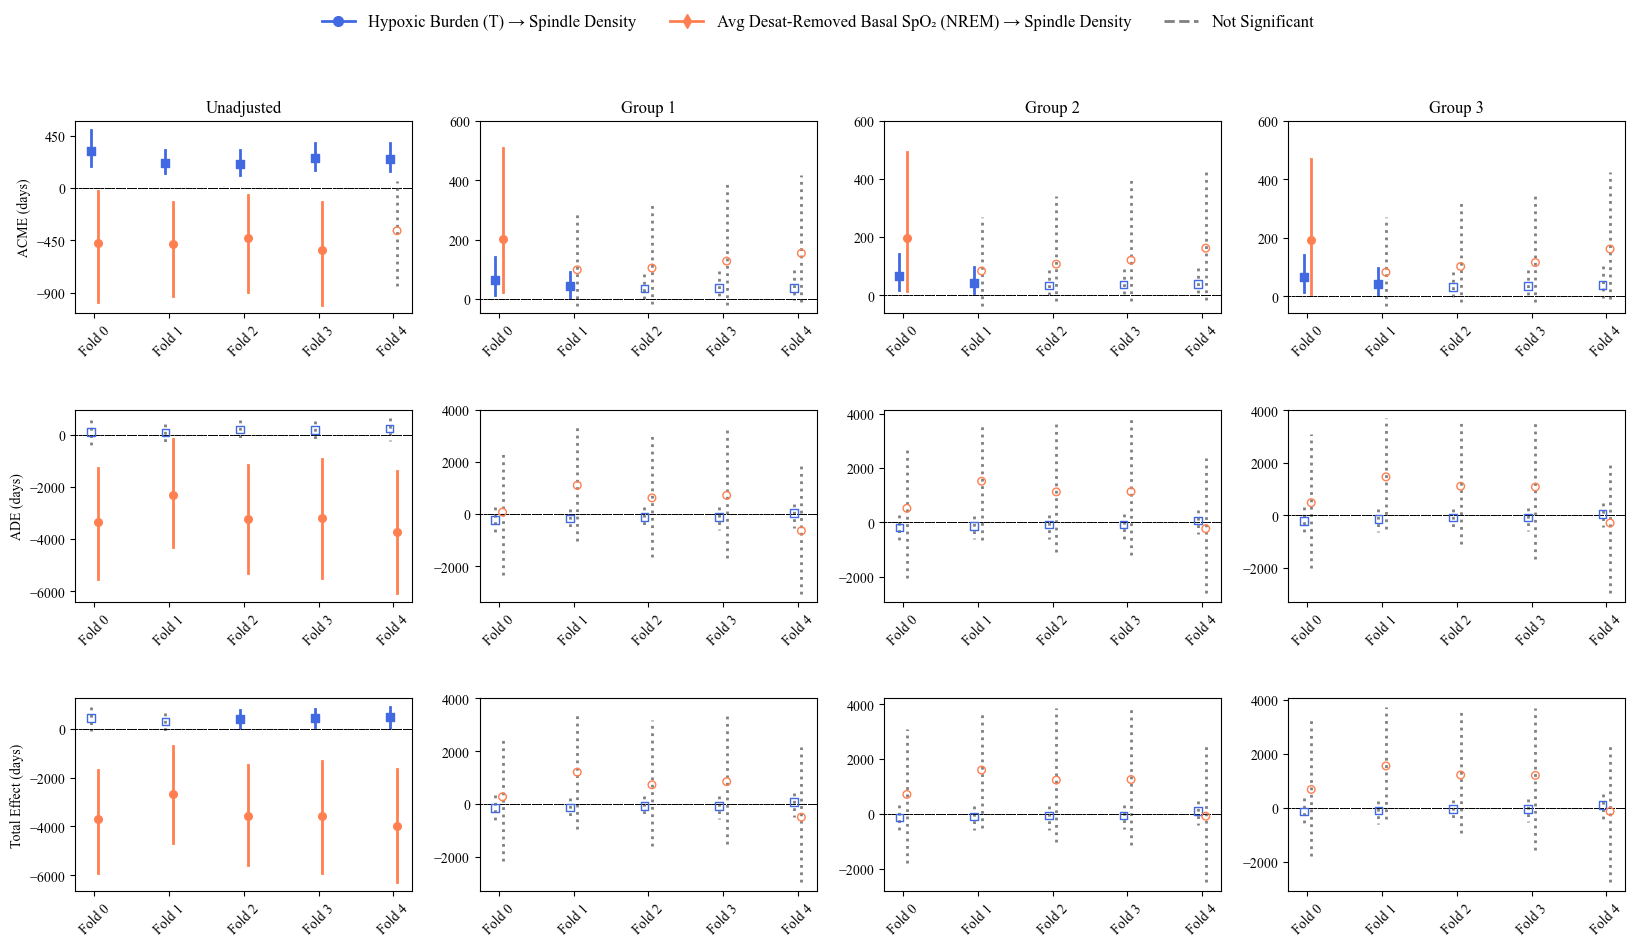

In [14]:
# Generating plot for results across folds for both significant pathways 

# Set labels
covariate_groups = ["Unadjusted", "Group1", "Group2", "Group3"]
effect_types = ["ACME", "ADE", "Total_Effect"]
fold_labels = ["Fold 0", "Fold 1", "Fold 2", "Fold 3", "Fold 4"]

# Set up plot
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5) 


# Set basic formatting 
colors = {"hb_desat": "royalblue",
    "avg_spo2_no_desat_NREM": "coral"}

offsets = {"hb_desat": -0.05,
    "avg_spo2_no_desat_NREM": 0.05}

marker_styles = {"hb_desat": "s",  
    "avg_spo2_no_desat_NREM": "o"}

open_marker_styles = {"hb_desat": "s",  
    "avg_spo2_no_desat_NREM": "o" }

covariate_labels = {
    "Unadjusted" : "Unadjusted",
    "Group1": "Group 1",
    "Group2": "Group 2",
    "Group3":"Group 3"
}

# Specify y ticks for plots 
yticks_dict = {
    "ACME": {"Unadjusted": [-900, -450, 0, 450],
        "Groups": [0, 200, 400, 600]},
    "ADE": {"Unadjusted": [-6000, -4000, -2000, 0],
            "Groups": [-2000, 0, 2000, 4000]},
    "Total_Effect": {"Unadjusted": [-6000, -4000, -2000, 0],
        "Groups": [-2000, 0, 2000, 4000]}
}


# Loop through both dfs to generate the 3x4 plot 
for df in [hb_density_df, spo2_density_df]:
    for index, row in df.iterrows():
        group = row["Covariate_Set"]
        fold = row["Fold"]
        exposure = row["Exposure"]
        
        col_idx = covariate_groups.index(group)
        fold_idx = fold_labels.index(fold)
        x = fold_idx + offsets[exposure]
        
        color = colors[exposure]

        # Plot CI and estimate values and notate with coloring for each effect type 
        for row_idx, effect in enumerate(effect_types):
            ax = axs[row_idx, col_idx]
    
            est = pd.to_numeric(row[effect], errors="coerce")
            lower = pd.to_numeric(row[f"{effect}_CI_Lower"], errors="coerce")
            upper = pd.to_numeric(row[f"{effect}_CI_Upper"], errors="coerce")
            is_sig = (lower > 0 and upper > 0) or (lower < 0 and upper < 0)
            ci_color = colors[exposure] if is_sig else "gray"
            marker_color = colors[exposure]

            ax.plot([x, x], [lower, upper], color=ci_color, lw=2, linestyle="-" if is_sig else ":")
            if is_sig:
                ax.scatter(x, est, color=marker_color, s=30, zorder=3, marker=marker_styles[exposure])
            else:
                ax.scatter(x, est, facecolors='none', edgecolors=marker_color, s=30, zorder=3, marker=open_marker_styles[exposure])

            # Set axis labels 
            ax.axhline(0, color="black", lw=0.5, linestyle="--")
            ax.set_xticks(range(5))
            ax.set_xticklabels(fold_labels, rotation=45)
            if row_idx == 0:
                ax.set_title(covariate_labels[group])

            # Rename Total Effect without the underscore 
            if col_idx == 0:
                if effect == "Total_Effect":
                    ax.set_ylabel("Total Effect (days)")
                else:
                    ax.set_ylabel(f"{effect} (days)")

            # Using different axes to account for drastic scale change between unadjusted and covariate-adjusted plots  
            ax.set_yticks(yticks_dict[effect]["Unadjusted"] if group == "Unadjusted" else yticks_dict[effect]["Groups"])
            ax.tick_params(axis='y', labelsize=10) 


# Setting legend at the top of the graph 
legend_elements = [
    Line2D([0], [0], marker='o', color='royalblue', label='Hypoxic Burden (T) → Spindle Density',
           linestyle='-', markersize=7, linewidth=2),
    Line2D([0], [0], marker='d', color='coral', label='Avg Desat-Removed Basal SpO₂ (NREM) → Spindle Density',
           linestyle='-', markersize=7, linewidth=2),
    Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Not Significant')
]

fig.legend(handles=legend_elements, loc='upper center', ncol=3, frameon=False, fontsize=12)


# Save and show the figure 
#plt.savefig("NAME FIGURE.png", dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()
plt.close()

### Five-fold validation performance table

In [15]:
# Generate performance table 
kfold_dataset0 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_0")
kfold_dataset1 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_1")
kfold_dataset2 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_2")
kfold_dataset3 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_3")
kfold_dataset4 = pd.read_excel("7.8.2025_k_fold_results.xlsx", sheet_name="Fold_4")

In [16]:
# Create list of 5 fold dataframes
fold_dfs = [kfold_dataset0, kfold_dataset1, kfold_dataset2, kfold_dataset3, kfold_dataset4]

# Concatenate all dfs together for table 
all_folds = pd.concat(fold_dfs, ignore_index=True)

# Keep only relevant columns for performance data 
columns_to_keep = [
    "Exposure", "Mediator", "Covariate_Set", "Fold",
    "C_Index", "C_Index_CI_Lower", "C_Index_CI_Upper", "RMSE", "Std_Dev_Y", "AUC_10y", "AUC_10y_CI_Lower", "AUC_10y_CI_Upper", 
    "AUC_15y", "AUC_15y_CI_Lower", "AUC_15y_CI_Upper"
]
filtered_df = all_folds[columns_to_keep].copy()
filtered_df = filtered_df.rename(columns={"C_Index":"C-Index", "Covariate_Set":"Covariates", "AUC_10y":"AUC (10y)",
                                          "AUC_15y":"AUC (15y)", "Std_Dev_Y":"SD (Mediator)"})

# Convert values to numeric to keep consistent datatype 
metric_cols = ["C-Index", "RMSE", "SD (Mediator)", "AUC (10y)", "AUC (15y)", "C_Index_CI_Lower", "C_Index_CI_Upper", 
               "AUC_10y_CI_Lower", "AUC_10y_CI_Upper", "AUC_15y_CI_Lower", "AUC_15y_CI_Upper" ]
filtered_df[metric_cols] = filtered_df[metric_cols].apply(pd.to_numeric, errors="coerce")

In [17]:
# Generate mean values for performance values  

# Custom aggregation: mean, lower CI avg, upper CI avg
agg_dict = {
    "C-Index": "mean",
    "C_Index_CI_Lower": "mean",
    "C_Index_CI_Upper": "mean",
    "RMSE": "mean",
    "SD (Mediator)": "mean",
    "AUC (10y)": "mean",
    "AUC_10y_CI_Lower": "mean",
    "AUC_10y_CI_Upper": "mean",
    "AUC (15y)": "mean",
    "AUC_15y_CI_Lower": "mean",
    "AUC_15y_CI_Upper": "mean"
}

# Apply aggregation to the df and groups by exposure/mediator/covariates
agg_df = filtered_df.groupby(["Exposure", "Mediator", "Covariates"]).agg(agg_dict).reset_index()


In [18]:
# Define custom pair and covariate group order
pair_order = [
    ("avg_spo2_no_desat_NREM", "SP_DENS_all_C"),
    ("avg_spo2_no_desat_NREM", "SP_CHIRP_all_C"),
    ("avg_spo2_no_desat_NREM", "SP_R_PHASE_IF_all_C"),
    ("hb_desat", "SP_DENS_all_C"),
    ("hb_desat", "SP_CHIRP_all_C"),
    ("hb_desat", "SP_R_PHASE_IF_all_C"),
]
cov_order = ["Unadjusted", "Group1", "Group2", "Group3"]

# Create and sort by exposure–mediator pair and covariate group
agg_df["Pair"] = list(zip(agg_df["Exposure"], agg_df["Mediator"]))
agg_df["Pair"] = pd.Categorical(agg_df["Pair"], categories=pair_order, ordered=True)
agg_df["Covariates"] = pd.Categorical(agg_df["Covariates"], categories=cov_order, ordered=True)
agg_df = agg_df.sort_values(["Covariates", "Pair"]).reset_index(drop=True)
agg_df.drop(columns={"Pair"}, inplace=True)

# Clean up label names
agg_df["Mediator"] = agg_df["Mediator"].replace({
    "SP_DENS_all_C": "Spindle Density",
    "SP_CHIRP_all_C": "Spindle Chirp",
    "SP_R_PHASE_IF_all_C": "Spindle-SO Coupling Phase"
})
agg_df["Exposure"] = agg_df["Exposure"].replace({
    "hb_desat": "Hypoxic Burden",
    "avg_spo2_no_desat_NREM": "Avg Desat-Removed Basal SpO₂ (NREM)"
})

# Round numerical columns
cols_to_round = [
    col for col in agg_df.columns
    if agg_df[col].dtype.kind in "fiu"
]
agg_df[cols_to_round] = agg_df[cols_to_round].round(3)


# Format to show the mean value with CI in one cell 
agg_df["C-Index (95% CI)"] = agg_df["C-Index"].astype(str) + "\n[" + agg_df["C_Index_CI_Lower"].astype(str) + "–" + agg_df["C_Index_CI_Upper"].astype(str) + "]"
agg_df["AUC (10y) (95% CI)"] = agg_df["AUC (10y)"].astype(str) + "\n[" + agg_df["AUC_10y_CI_Lower"].astype(str) + "–" + agg_df["AUC_10y_CI_Upper"].astype(str) + "]"
agg_df["AUC (15y) (95% CI)"] = agg_df["AUC (15y)"].astype(str) + "\n[" + agg_df["AUC_15y_CI_Lower"].astype(str) + "–" + agg_df["AUC_15y_CI_Upper"].astype(str) + "]"


# Select final columns 
relevant_perf = agg_df[["Exposure", "Mediator", "Covariates", "RMSE", "SD (Mediator)", "C-Index (95% CI)", 
                        "AUC (10y) (95% CI)", "AUC (15y) (95% CI)"]].copy()

print(relevant_perf.head())

                              Exposure                   Mediator  Covariates  \
0  Avg Desat-Removed Basal SpO₂ (NREM)            Spindle Density  Unadjusted   
1  Avg Desat-Removed Basal SpO₂ (NREM)              Spindle Chirp  Unadjusted   
2  Avg Desat-Removed Basal SpO₂ (NREM)  Spindle-SO Coupling Phase  Unadjusted   
3                       Hypoxic Burden            Spindle Density  Unadjusted   
4                       Hypoxic Burden              Spindle Chirp  Unadjusted   

    RMSE  SD (Mediator)      C-Index (95% CI)    AUC (10y) (95% CI)  \
0  0.929          0.932   0.628\n[0.565–0.69]  0.678\n[0.517–0.839]   
1  0.122          0.123  0.588\n[0.522–0.655]  0.587\n[0.363–0.812]   
2  0.215          0.215  0.598\n[0.535–0.661]  0.597\n[0.441–0.754]   
3  0.917          0.932  0.616\n[0.554–0.679]  0.674\n[0.516–0.832]   
4  0.122          0.123  0.581\n[0.516–0.646]  0.564\n[0.354–0.773]   

     AUC (15y) (95% CI)  
0  0.691\n[0.585–0.796]  
1  0.618\n[0.494–0.741]  
2  0.638

In [19]:
# Export to excel 
# relevant_perf.to_excel("NAME FILE.xlsx", index=False)